In [1]:
import math
import numpy as np
import pandas as pd
import sys
import itertools
from functions import *
from mining_functions import *
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

In [29]:
merge_actions = {'C':'C', 'P':'P', 'Tb':'T', 'Tc':'T', 'Ts':'T', 'To':'T'}

def make_hist_discrete(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    ymax= max(max(freq_HL),max(freq_LL))
    bins = range(0,int(ymax)+1,1)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return None

def make_hist_continuous(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    plt.hist(freq_HL,color ='r',alpha = 0.4)
    plt.hist(freq_LL,color = 'b',alpha = 0.4)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return None

def get_frequencies(seq_of_interest,blocks1,blocks2,normalize_by='length'):
    if normalize_by == None:
        freq1 = {student : float(''.join(seq).count(seq_of_interest)) for student,seq in blocks1.iteritems()}
        freq2 = {student : float(''.join(seq).count(seq_of_interest)) for student,seq in blocks2.iteritems()}
    elif normalize_by == 'length':
        freq1 = {student : float(''.join(seq).count(seq_of_interest))/len(seq) for student,seq in blocks1.iteritems()}
        freq2 = {student : float(''.join(seq).count(seq_of_interest))/len(seq) for student,seq in blocks2.iteritems()}
    else:
        freq1 = {student : float(''.join(seq).count(seq_of_interest))/''.join(seq).count(normalize_by) for student,seq in blocks1.iteritems()}
        freq2 = {student : float(''.join(seq).count(seq_of_interest))/''.join(seq).count(normalize_by) for student,seq in blocks2.iteritems()}
    return freq1.values(),freq2.values()

# Story line
This notebook raises and explores hypotheses generated fom the analysis in the notebook  "temporal_sequence_infogain_mining.ipynb"

Here are the Hypotheses:
* CTsPTsP (HL)
    * TsP
        * Ts (**1.1**)
        * TP (**1.2**)
    * TsPTsP
        * TPTP (**2.1**)
* PCTcCTcC (LL)
    * TcC
        * Tc (**3.1**)
        * TC (**3.2**)
    * TcCTcC
        * TCTC (**4.1**)
* PCPCTcC (LL)
    * PC (**5.1**)
    * CP (**5.2**)
* PTsPC (HL)
    * PTs
    * PT (**6**)


# Frequency analysis of single blocks of actions -> Hypotheses 1.1 and 3.1
First we get the sequence of action of each students in blocks. Recall that we only look at students who had a low pre.
We also ignore the Interface becasue they aren't interesting.

In [4]:
students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
students_HL = H_post.intersection(students_Lpre)
students_LL = L_post.intersection(students_Lpre)
print "There are {0} low pre students, of which {1} are high learners and {2} low learners.".format(len(students_Lpre),len(students_HL),len(students_LL))

There are 74 low pre students, of which 38 are high learners and 36 low learners.


In [5]:
blocks_HL, time_coords_HL =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I'], as_list=True)
blocks_merged_HL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_HL.iteritems()}
blocks_merged_LL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_LL.iteritems()}
actions_merged = ['C','P','T']
actions_all = ['C', 'P', 'Tb', 'Tc', 'Ts']

We may need to plot sequences so let's load them up

In [6]:
CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
shortest_seq_length = 1
longest_seq_length = 10
B = 4  #number of bins
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students_Lpre,family_category,
                                                          B,'split post t2','high','low',
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


First we need to check that students tend to do the same number of blocks of actions in their sequences

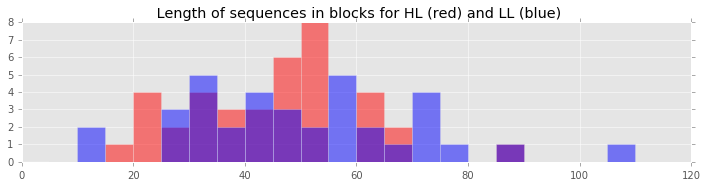

In [7]:
length_HL = [len(seq) for seq in blocks_HL.values()];length_LL = [len(seq) for seq in blocks_LL.values()]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= max(max(length_HL),max(length_LL))
bins = range(0,ymax+5,5)
plt.hist(length_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(length_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Length of sequences in blocks for HL (red) and LL (blue)")

Indeed they do not! We are going to have to normalize given the length of each student's sequence

In [16]:
for action in actions_all:
    freq_HL,freq_LL = get_frequencies(action,blocks_HL,blocks_LL,normalize_by=None)
#     make_hist_discrete(action,freq_HL,freq_LL)
#     plot_heat_map(sequence_counts[action],action,('high','low'))

We notice that:
* Everyone constructs and pause during the entire activity
* Everyone Test simple and basic early as well as Test complex late. 
* some students never Test basic (13 LL, 6 HL) nor Test simple (13 LL and 5 HL).
* Several LL do many many Test complex actions, and do them earlier on in the activity
* Several LL have more Construct blocks.

Note that we don't look at Test other because only 9 students use it.

We can do some t-tests to confirm that most patterns above are not significant.


## Let's repeat the analysis normalizing by sequence length

C :
	T-test:	-2.459 	 p=0.017
	HL<LL:	427.0 	 p=0.003
	HL>LL:	427.0 	 p=0.997
P :
	T-test:	1.141 	 p=0.258
	HL<LL:	784.5 	 p=0.863
	HL>LL:	784.5 	 p=0.14
Tb :
	T-test:	0.69 	 p=0.492
	HL<LL:	799.5 	 p=0.897
	HL>LL:	799.5 	 p=0.105
Tc :
	T-test:	-0.568 	 p=0.572
	HL<LL:	630.5 	 p=0.283
	HL>LL:	630.5 	 p=0.72
Ts :
	T-test:	0.68 	 p=0.499
	HL<LL:	763.5 	 p=0.808
	HL>LL:	763.5 	 p=0.195


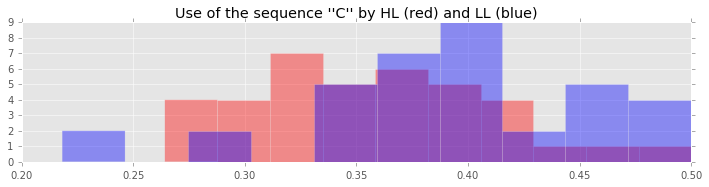

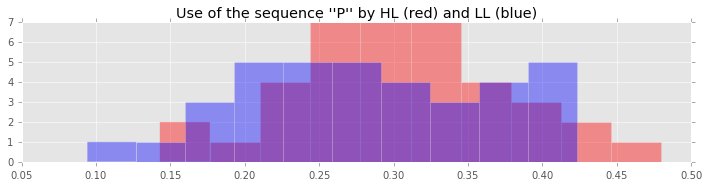

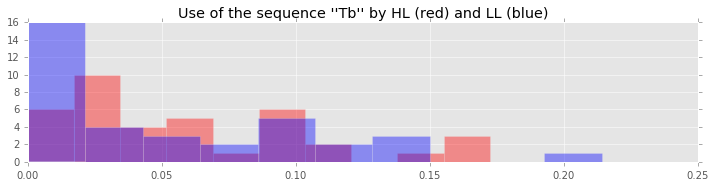

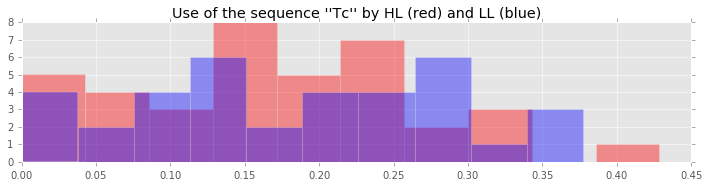

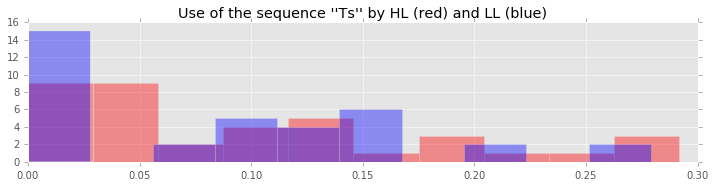

In [27]:

def perform_comparative_stats(seq_of_interest,freq1,freq2):
    t,p =  stats.ttest_ind(freq_HL,freq_LL,equal_var=False)
    print seq_of_interest,':'
    print "\tT-test:\t{0} \t p={1}".format(round(t,3),round(p,3))
    m,p = stats.mannwhitneyu(freq_HL,freq_LL, alternative='less')
    print '\tHL<LL:\t{0} \t p={1}'.format(round(m,3),round(p,3))
    m,p = stats.mannwhitneyu(freq_HL,freq_LL, alternative='greater')
    print '\tHL>LL:\t{0} \t p={1}'.format(round(m,3),round(p,3))

for action in actions_all:
    freq_HL,freq_LL = get_frequencies(action,blocks_HL,blocks_LL,normalize_by='length')
    make_hist_continuous(action,freq_HL,freq_LL)
    perform_comparative_stats(action,freq_HL,freq_LL)

** <font color='blue'> Clearly, LL have more construction blocks given the number of blocks they have ($p < 0.05$) </font> **

# Let's start digging into our Hypotheses
## Hypothesis 1.2 and 3.2: What to do after testing? 
### HL do more TsP?

In [31]:
seq = 'TsP'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='Ts')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

ZeroDivisionError: float division by zero

### LL do more TcC?

In [ ]:
run_frequency_analysis('TcC',blocks_HL,blocks_LL,sequence_counts

** <font color='blue'> LL Test complex + Construct more ($p < 0.05$) </font> **

But HL do not significantly Test simple and Pause more.

### Let's generalize these hypotheses and repeat the analysis for TP and TC
We merge all test actions (and don't ignore Test Other for this analysis)

In [ ]:
run_frequency_analysis_with_merge('TP',blocks_HL,blocks_LL,sequence_counts)

In [ ]:
run_frequency_analysis_with_merge('TC',blocks_HL,blocks_LL,sequence_counts)

Visibly there is a trend however it is not significant. 
## Hypothesis 5.1 and 5.2: LL do more CP or PC?

In [ ]:
run_frequency_analysis_with_merge('CP',blocks_HL,blocks_LL,sequence_counts)

In [ ]:
run_frequency_analysis_with_merge('PC',blocks_HL,blocks_LL,sequence_counts)

Once again, visisbly there is a trend however it is not significant.
## So everyone pauses during the activity, but they possibly use pauses differently...

In [ ]:
plot = plot_heat_map(sequence_counts['P'],'P',('high','low'))

In [ ]:
for seq in ['TPC','CPT','TPT','CPC']:
    run_frequency_analysis_with_merge(seq,blocks_HL,blocks_LL,sequence_counts)

## What about repetitions of building blocks?